# *Answering Business Questions using SQL*

### Introduction and Schema Diagram

- In this project we're working with a modified version of a database called `Chinook`. `The Chinook database` contains information about a fictional digital music shop - kind of like a mini-iTunes store.

- `The Chinook database` contains information about the artists, songs, and albums from the music shop, as well as information on the `shop's employees`, `customers`, and `the customers purchases`. This information is contained in eleven tables.

- ***We'll run queries and provide solutions to 4 Business Questions.***

<img src="files/chinook-schema.svg">

### *Scenario 1 : Selecting Albums to Purchase*

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. 

All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name | Genre|
|-|-|
|Regal |	Hip-Hop |
|Red Tone |	Punk |
|Meteor and the Girls |	Pop |
|Slim Jim Bites |	Blues |

### <font color=Orange>***Business Question***</font>
***The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.***

### Creating Helper Functions

- First, we'll import `SQLite`, `pandas` and `matplotlib` modules, and use the magic command `%matplotlib inline` to make sure any plots render in the notebook.
- Next, we will create three helper functions:
    - A `run_query()` function, that takes a SQL query as an argument and returns a pandas dataframe of that query.
    - A `run_command()` function that takes a SQL command as an argument and executes it using the sqlite module.
    - A `show_tables()` function that calls the run_query() function to return a list of all tables and views in the database.
- Next, we will run the `show_tables()` function.

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
    SELECT 
        name, 
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");'''
    return run_query(q)

show_tables()    

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Finding Best-Selling Genres

- We will write a query that returns each genre, with the number of tracks sold in absolute numbers and in percentages.
- And, then create a plot to show this data.

In [2]:
q1 = '''
WITH tracks_sold_usa AS 
    (
    SELECT il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = 'USA'
    )
    
SELECT 
    g.name,
    COUNT(tsu.invoice_line_id) 'tracks_sold',
    CAST(COUNT(tsu.invoice_line_id) AS FLOAT)/ (SELECT COUNT(*) FROM tracks_sold_usa) 'tracks_sold_perc'
FROM tracks_sold_usa tsu
INNER JOIN track t ON tsu.track_id = t.track_id 
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
'''

**Genres with Amount of Tracks Sold**

In [3]:
run_query(q1)

,name,tracks_sold,tracks_sold_perc
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


**Plotting Genre vs Track Percentage**

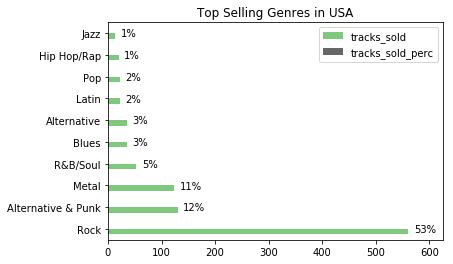

In [4]:
genre_albums_sold = run_query(q1)
genre_albums_sold.set_index("name", drop=True, inplace=True)

genre_albums_sold.plot.barh(
    title = "Top Selling Genres in USA",
    xlim = (0, 625),
    colormap = plt.cm.Accent
)

plt.ylabel('')

for key, value in enumerate(list(genre_albums_sold.index)):
    score = genre_albums_sold.loc[value, 'tracks_sold']
    label = (genre_albums_sold.loc[value, 'tracks_sold_perc'] * 100).astype(int).astype(str) + '%'
    plt.annotate(str(label), (score+10, key - 0.15))

plt.show()

***RECOMMENDATION:***

The recommended artists according to popularity of their genres (in Descreasing Order) are:
- _Red Stone (Punk) (12%)_
- _Slim Jim Bites (Blues) (3%)_
- _Meteor and the Girls (Pop) (2%)_

**However, the total sales of these genres combined is just 17%. <br>We should instead look out for artists in Rock genre, since it alone sells for 53%**
***

### *Scenario 2: Analysing Employee Sales Performance*

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. 

### <font color=Orange>***Business Question***</font>
***We want to analyze Employee Sales Performance. <br>For this we will have to analyze the purchases of customers belonging to each employee.***

### Finding Top Sales Employees

- We will write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. 
- We would need to add some extra attributes for the employees (e.g Date of joining, etc). Since they are relevant to the analysis.

In [5]:
q2 = '''
SELECT 
    e.first_name || " " || e.last_name 'Employee Name',
    e.hire_date 'Hiring Date',
    SUM(total) 'Sales'
FROM invoice i 
INNER JOIN customer c ON c.customer_id = i.customer_id
INNER JOIN employee e ON e.employee_id = c.support_rep_id
GROUP BY c.support_rep_id
'''

**Employees with Hiring Dates and Sales**

In [6]:
run_query(q2)

,Employee Name,Hiring Date,Sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


**Plotting Employees vs Sales Data**

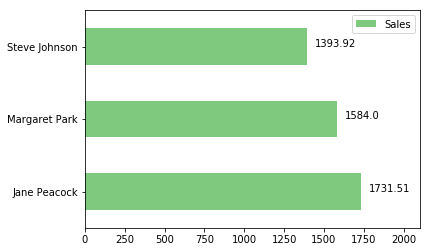

In [7]:
employee_sales = run_query(q2)
employee_sales.set_index("Employee Name", drop=True, inplace=True)
employee_sales.plot.barh(
    colormap = plt.cm.Accent,
    xlim = (0, 2100)
)

for key, value in enumerate(list(employee_sales.index)):
    plt.annotate(str(employee_sales.loc[value, 'Sales'].round(2)), (employee_sales.loc[value,'Sales'] +50, key))

plt.ylabel('')
plt.show()

***RECOMMENDATION:***

**Here Mr. Jean Peacock has a margin of around 20% compared to the lowest performer (Mr. Steve Johnson).<br>However, we may also note that the difference in Hiring Date corresponds to the Sales difference.**

***

### *Scenario 3: Analysing Sales By Country*

### <font color=Orange>***Business Question***</font>
***We want to analyze Sales By country. In particular, we will calculate:***
- ***total number of customers***<br>
- ***total value of sales***
- ***average value of sales per customer***
- ***average order value***

### *Table* - Total No. of Customers, Sales,  Average Sales, Average Orders Per Country

- We will write a query that collates data on purchases from different countries
- Whenever a country has only one customer, we'll collect them into an "Other" group.
- The results will be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.

In [8]:
q3 = '''
WITH country_or_other AS
    (
     SELECT 
         CASE
             WHEN
             (SELECT 
                 COUNT(*)
             FROM customer
             WHERE country = c.country
             ) = 1 THEN 'Other'
             ELSE c.country
         END AS country,
         c.customer_id,
         il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
    
SELECT
    Country,
    Customers,
    Total_sales,
    Average_customer_life,
    Average_order
FROM 
    (
     SELECT 
         country 'Country',
         COUNT(DISTINCT customer_id) 'Customers',
         SUM(unit_price) 'Total_sales',
         SUM(unit_price) / COUNT(DISTINCT customer_id) 'Average_customer_life',
         SUM(unit_price) / COUNT(DISTINCT invoice_id) 'Average_order',
         CASE 
             WHEN country = 'Other' THEN 1
             ELSE 0
         END AS sort
     FROM country_or_other
     GROUP BY country
     ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(q3)

,Country,Customers,Total_sales,Average_customer_life,Average_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


### Plotting Sales By Country

- For each dimension, we will create a visualization which demonstrates the data collated in previous step.

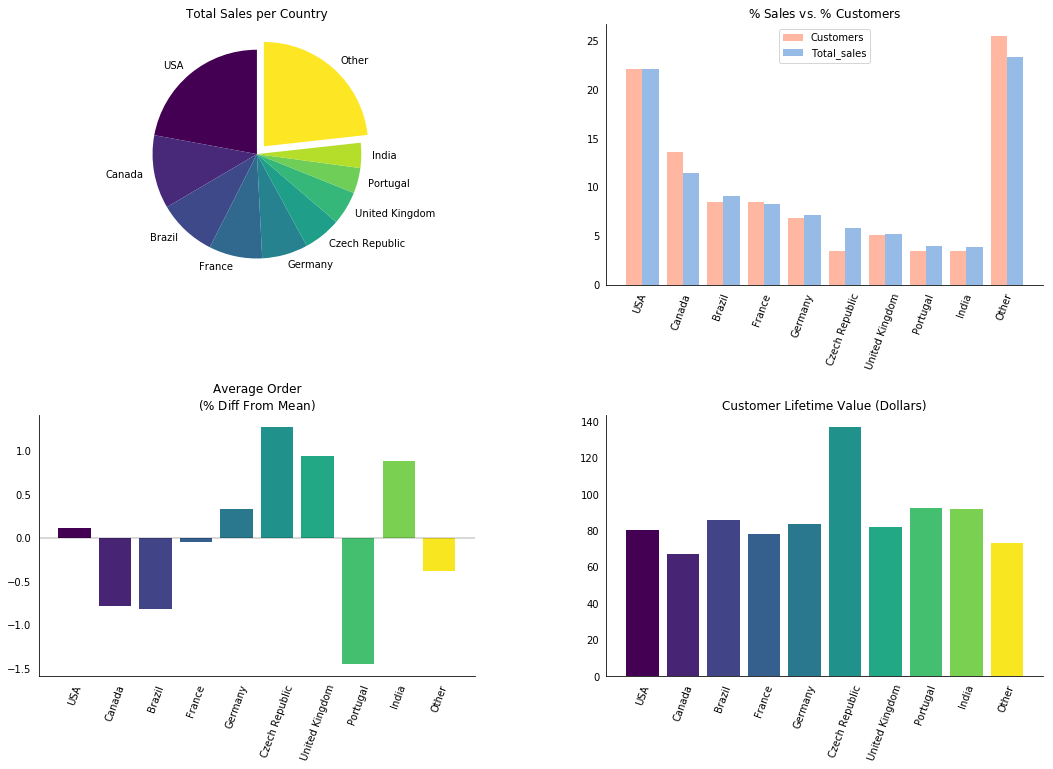

In [13]:
from numpy import arange
import matplotlib

# Required Dataframe
country_sales = run_query(q3) 
country_sales.set_index('Country', inplace=True, drop=True)

# Cols is array containing names of columns to be plotted
cols = list(country_sales.columns)

# Required Figure Container
fig = plt.figure(figsize = (18, 12))
fig.subplots_adjust(hspace=.5, wspace=.3)

# Bar Positions (Left) for Bar Plots
positions = arange(country_sales.shape[0])

# Colors Array for Bar Plots
colors = matplotlib.cm.get_cmap('viridis')
arr1 = np.append(arange(0, 0.9, 0.1), [0.99])
rgba = list(colors(i) for i in arr1)

#################################
#Top Left (Total_sales)(PieChart)
ax1 = fig.add_subplot(2, 2, 1)

# Column to be plotted copied from Dataframe
customers_in_country = country_sales[cols[1]].copy().rename('')

# Explode is used for Removing a part of Pie a littel bit to highlight 
explode = list(0.1 if i == 'Other' else 0 for i in customers_in_country.index)

# Plotting Data
ax1 = customers_in_country.plot(
    kind='pie',
    colormap = plt.cm.viridis,
    startangle = +90,
    explode = explode,
    title = 'Total Sales per Country'
    )
ax1.set_ylabel('')

#########################################################
# Top Right (Pct Sales vs Pct Customers) (Grouped Bar Plot)
ax2 = fig.add_subplot(2, 2, 2)

# Columns to be Plotted
cust_vs_sales_cols = cols[:2]
cust_vs_sales = country_sales[cust_vs_sales_cols].copy()
cust_vs_sales.index.name = ''

for i in cust_vs_sales_cols:
    cust_vs_sales[i] /= cust_vs_sales[i].sum() / 100
        
# Plotting Data
ax2.bar(
    [x - 0.15 for x in positions],
    cust_vs_sales['Customers'],
    0.4,
    color = "#FFB7A2"

)
ax2.bar(
    [0.25 + x for x in positions],
    cust_vs_sales['Total_sales'],
    0.4,
    color = '#96BBE6'
)

ax2.set_title('$\%$ Sales vs. $\%$ Customers')
ax2.legend(list(cust_vs_sales.columns), loc='upper center')

###########################################################
# Bottom Left (Average Order (Pct Diff From Mean)) (Bar Plot)
ax3 = fig.add_subplot(2, 2, 3)
avg_cust_order = country_sales['Average_order'].mean()
diff_from_avg = country_sales['Average_order'] - avg_cust_order

ax3.bar(
    positions,
    diff_from_avg,
    color = rgba
)
ax3.axhline(0, c=(0/255, 0/255, 0/255), alpha=0.2)
ax3.set_title('Average Order\n($\%$ Diff From Mean)')

# ##########################################################
# Bottom Right(Customer Lifetime Value (Dollars)) (Bar Plot)
ax4 = fig.add_subplot(2, 2, 4)
ax4.bar(
    positions,
    country_sales['Average_customer_life'],
    color = rgba
)
ax4.set_title('Customer Lifetime Value (Dollars)')

##########################################################
# Improving Plot Aesthetics
axes_objects = [ax2, ax3, ax4]
for i in axes_objects:
    i.tick_params(top=False, right=False, left=False, bottom=False)
    i.set_xticks(arange(cust_vs_sales.shape[0]))
    i.set_xticklabels(country_sales.index, rotation = 70)
    for k, v in i.spines.items():
        if (k == 'right' or k == 'top'):
            v.set_visible(False)
            
plt.savefig('Comparison.png')
plt.show()

### RECOMMENDATION

***Based on the data, there may be opportunity in the following countries:***

> *Czech Republic<br>
United Kingdom<br>
India<br>*

***It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.***

***

### *Scenario 4: Analyze purchases of Albums vs Individual Tracks*

In the `Chinook store`, customers are not allowed to purchase a whole album, and then add individual tracks to that same purchase. When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management is considering a change in the purchasing strategy to save money. The new strategy is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

### <font color=Orange>***Business Question***</font>
***We want to analyze what percentage of purchases are individual tracks vs whole albums. It will help management to understand the effect this decision might have on overall revenue.***


### Finding Number and Percentage of invoices in Categories (Album vs Tracks)

- We will write two queries:
    - First, we will categorize each invoice as either an album purchase or not.
    - Second, we will calculate the following summary statistics:
        - Number of invoices
        - Percentage of invoices

In [14]:
q4 = '''
WITH invoice_first_track AS 
    (
    SELECT 
        invoice_id,
        MIN(track_id) 'first_track_id'
    FROM invoice_line
    GROUP BY 1
    )
    
SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
'''

run_query(q4)

,invoice_id,first_track_id,album_purchase
0,1,1158,yes
1,2,201,no
2,3,2516,no
3,4,748,no
4,5,1986,yes
5,6,30,no
6,7,42,no
7,8,81,no
8,9,196,no
9,10,2663,no


***Statistics based on above data***

In [15]:
q6 = '''
WITH invoice_first_track AS
    (
    SELECT 
        invoice_id,
        MIN(track_id) 'first_track_id' 
    FROM invoice_line
    GROUP BY 1
    )

SELECT 
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT)*100 / (SELECT COUNT(*) FROM invoice) 'percent'
FROM 
    (
    SELECT 
        ifs.*,
        CASE
            WHEN
                (
                SELECT t1.track_id from track t1
                WHERE t1.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = ifs.first_track_id
                                    )
                EXCEPT
                
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ifs.invoice_id
                ) IS NULL
            AND
                (
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ifs.invoice_id
                
                EXCEPT
                
                SELECT t1.track_id from track t1
                WHERE t1.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = ifs.first_track_id
                                    )
                ) IS NULL            
            THEN 'yes'
            ELSE 'no'
        END AS 'album_purchase'
    FROM invoice_first_track ifs
    )
GROUP BY 1
'''

run_query(q6)

,album_purchase,number_of_invoices,percent
0,no,500,81.433225
1,yes,114,18.566775


### RECOMMENDATION

***Here, we can we observe that there are around 18.5% purchases are being done as complete albums.<br><br>So we may recommend against going for only individual tracks. Since, around 1/5th of the revenue is being generated by Albums. However, more analysis needs to be done in order to provide a sound recommendation.***